In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


**Prepare & Handle Data**

In [ ]:
df = pd.read_csv('sp500_dataset.csv')

In [ ]:
df.tail()

,Unnamed: 0,DATE,15dH,15dL,15dC,15dV,OBV,Date_N,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP,NFCI,Close
507,508,2024-05,5311.759766,5011.049805,5179.954634,4.099039e+09,2.498673e+11,6.666667,2.342961,1.938194,313.207,5.33,3.9,28652.337000,-0.49802,5277.509766
508,509,2024-06,5447.250000,5234.319824,5365.119971,3.677121e+09,2.535444e+11,6.833333,2.451501,2.103399,313.225,5.33,4.0,28929.309591,-0.51725,5460.479980
509,510,2024-07,5666.939941,5446.529785,5570.316016,3.334765e+09,2.568792e+11,7.000000,2.367064,1.999567,313.049,5.33,4.1,29206.282182,-0.51934,5522.299805
510,511,2024-08,5566.160156,5119.259766,5350.892800,4.189773e+09,2.526894e+11,7.166667,2.368186,2.048396,313.534,5.33,4.3,29483.254773,-0.49531,5648.399902
511,512,2024-09,5636.270020,5402.620117,5522.589952,3.706486e+09,2.563959e+11,7.333333,2.164069,1.664190,314.121,5.33,4.2,29483.254773,-0.55834,5762.479980


In [ ]:
X = df.iloc[:,2:-1]
y = df.iloc[:,-1:]
X.head()

,15dH,15dL,15dC,15dV,OBV,Date_N,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP,NFCI
0,119.809998,112.820000,115.773000,4.822900e+07,1.251050e+09,-38.916667,6.197611,7.623742,94.4,13.22,8.6,3274.302000,1.94193
1,114.800003,104.459999,109.920908,6.159818e+07,1.189452e+09,-38.833333,6.079232,7.656648,94.7,14.78,8.9,3293.525333,2.09219
2,117.120003,111.480003,115.485001,5.063500e+07,1.240087e+09,-38.750000,5.648130,7.128993,94.7,14.68,9.0,3312.748667,2.17164
3,119.919998,115.910004,118.330000,5.670600e+07,1.296793e+09,-38.666667,5.713188,7.408347,95.0,14.94,9.3,3331.972000,2.38438
4,112.480003,108.529999,110.446363,4.866182e+07,1.248131e+09,-38.583333,5.689980,7.320041,95.9,14.45,9.4,3343.422000,2.80708


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)


**Linear Model Feature Selection**

In [ ]:
#Choosing the feature with the best performance in a linear regression model
mse_list1=[]
pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
for i in range(3):
  y_pred = cross_val_predict(pipe1, X.iloc[:,i].to_frame(), y, cv=kf)
  mse_list1.append(mean_squared_error(y, y_pred))
mse_list1

[5119.127472580274, 5305.161739465999, 4469.867591823426]

In [ ]:
#15dC shows the min mse and thus is reserved for the linear model
pipe1.fit(X['15dC'].to_frame(),y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

**Polynomial Model Feature & Degree Selection**

In [ ]:
!pip install scikit-optimize
!pip install 'scikit-optimize[plots]'
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from skopt.space import Real, Categorical, Integer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.3 MB/s eta 0:00:00


In [ ]:
#Choosing the feature (combination) with the best performance in a polynomial regression model
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(include_bias=True)),
    ('regressor', LinearRegression())
])
param_grid = {'poly_features__degree': [1, 2, 3, 4, 5]} #degree is only up to 5 to prevent overfitting
grid1 = GridSearchCV(pipe2, param_grid, cv=kf, scoring='neg_mean_squared_error')
best_list2=[]
for i in range(3):
  grid1.fit(X.iloc[:,(i*3)+5].to_frame(), y)
  degree = grid1.best_params_
  best_score = -grid1.best_score_
  best_list2.append([degree,best_score])

In [ ]:
best_list2

[[{'poly_features__degree': 5}, 52231.67123944669],
 [{'poly_features__degree': 5}, 84386.73452343517],
 [{'poly_features__degree': 4}, 61228.01776874219]]

In [ ]:
#Date_N with degree=5 has the best performance among the 3 yet still terrible. let's try to compare it with all 3 together.
grid1.fit(X.iloc[:,np.r_[5,8,11]], y)
[grid1.best_params_, -grid1.best_score_]

[{'poly_features__degree': 4}, 13115.838241473593]

In [ ]:
#Using all the 3 features yield much better result. Let's compare it to OBV alone though.
grid1.fit(X.iloc[:, 4].to_frame(), y)
[grid1.best_params_, -grid1.best_score_]

[{'poly_features__degree': 5}, 21265.972621017758]

In [ ]:
#Let's try to use all 4 features
grid1.fit(X.iloc[:, np.r_[4,5,8,11]], y)
[grid1.best_params_, -grid1.best_score_]

[{'poly_features__degree': 4}, 11954.009923400718]

In [ ]:
#Using Date_N, CPIAUCSL, and GDP only with degree=4 yield the min mse and thus is reserved for the polynomial model
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4)),
    ('regressor', LinearRegression())
])
pipe2.fit(X.iloc[:,np.r_[4,5,8,11]],y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_features', PolynomialFeatures(degree=4)),
                ('regressor', LinearRegression())])

**XGBoost Model Feature Selection**

In [ ]:
#Evaluate the performance of a XGB model with all features and defaulted params
import xgboost as xgb
pipe3 = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=1))
])
y_pred = cross_val_predict(pipe3, X, y, cv=kf)
mse = mean_squared_error(y, y_pred, squared=True)
mse

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7591.300145267203

In [ ]:
#It yields a pretty good result. Let's see if we can improve it by reducing some features

In [ ]:
#Method 1: Sentimental Elimination

pipe3.fit(X,y) #this step is to extract the feature importance, not for evaluation. so it is fine to include the whole dataset.

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=1, ...))])

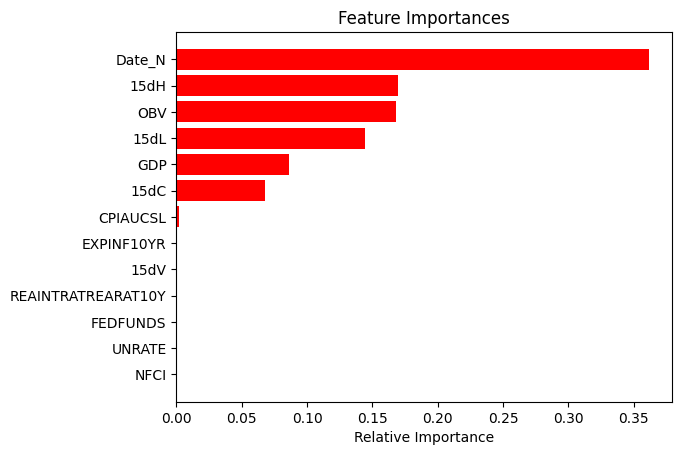

In [ ]:
xgb0 = pipe3.named_steps['reg']

# Get feature importance
feature_importance = xgb0.get_booster().get_score(importance_type='gain')
importances = xgb0.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#Features not within the top 6 seem to be irrevalent. Let's get rid of them
XGBX = X[['Date_N','15dH','OBV','15dL','GDP','15dC']]
XGBX.head()

,Date_N,15dH,OBV,15dL,GDP,15dC
0,-38.916667,119.809998,1.251050e+09,112.820000,3274.302000,115.773000
1,-38.833333,114.800003,1.189452e+09,104.459999,3293.525333,109.920908
2,-38.750000,117.120003,1.240087e+09,111.480003,3312.748667,115.485001
3,-38.666667,119.919998,1.296793e+09,115.910004,3331.972000,118.330000
4,-38.583333,112.480003,1.248131e+09,108.529999,3343.422000,110.446363


In [ ]:
#Gradually reducing the features starting from 6 to 1
y_pred = cross_val_predict(pipe3, XGBX, y, cv=kf)
mse = mean_squared_error(y, y_pred, squared=True)
mse_list3=[mse]
for i in range(5):
  y_pred = cross_val_predict(pipe3, XGBX.iloc[:,:-1-i], y, cv=kf)
  mse = mean_squared_error(y, y_pred, squared=True)
  mse_list3.append(mse)
y_pred = cross_val_predict(pipe3, XGBX.iloc[:,0].to_frame(), y, cv=kf)
mse_list3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

[7453.981257417858,
 7577.887779351547,
 7954.482511131119,
 8914.660189410151,
 7739.99433032531,
 7079.068652457502]

In [ ]:
#Method 2: recursive feature elimination
#Try to get the best combination of features when feature number is ranged from 2 to 13
from sklearn.feature_selection import RFE
best_list4 = []
for i in range(12):
  rfe = RFE(estimator=xgb0, n_features_to_select=i+2, step=1)
  pipe4 = Pipeline([
      ('scaler', StandardScaler()),
      ('feature_selection', rfe),
      ('reg', xgb0)
  ])
  pipe4.fit(X, y)
  selected_features = rfe.support_
  feature_ranking = rfe.ranking_
  y_pred = cross_val_predict(pipe4, X.iloc[:,selected_features], y, cv=kf)
  mse = mean_squared_error(y, y_pred, squared=True)
  best_list4.append([selected_features,mse])
best_list4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

[[array([ True, False, False, False, False,  True, False, False, False,
         False, False, False, False]),
  7940.781168063886],
 [array([ True,  True, False, False, False,  True, False, False, False,
         False, False, False, False]),
  8036.152848911042],
 [array([ True,  True, False, False,  True,  True, False, False, False,
         False, False, False, False]),
  8350.201809746752],
 [array([ True,  True,  True, False,  True,  True, False, False, False,
         False, False, False, False]),
  8412.177495157815],
 [array([ True,  True,  True, False,  True,  True, False, False, False,
         False, False,  True, False]),
  7510.476275060224],
 [array([ True,  True,  True, False,  True,  True, False, False,  True,
         False, False,  True, False]),
  7057.645901346641],
 [array([ True,  True,  True,  True,  True,  True, False, False,  True,
         False, False,  True, False]),
  7059.236882489398],
 [array([ True,  True,  True,  True,  True,  True, False,  True,  Tru

In [ ]:
#It is found that the dataset without FEDFUNDS, UNRATE and NFCI yields the best result (6785), even better than Date_N alone
XGBX2 = X.drop(['FEDFUNDS','UNRATE','NFCI'], axis=1)
XGBX2.head()

,15dH,15dL,15dC,15dV,OBV,Date_N,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,GDP
0,119.809998,112.820000,115.773000,4.822900e+07,1.251050e+09,-38.916667,6.197611,7.623742,94.4,3274.302000
1,114.800003,104.459999,109.920908,6.159818e+07,1.189452e+09,-38.833333,6.079232,7.656648,94.7,3293.525333
2,117.120003,111.480003,115.485001,5.063500e+07,1.240087e+09,-38.750000,5.648130,7.128993,94.7,3312.748667
3,119.919998,115.910004,118.330000,5.670600e+07,1.296793e+09,-38.666667,5.713188,7.408347,95.0,3331.972000
4,112.480003,108.529999,110.446363,4.866182e+07,1.248131e+09,-38.583333,5.689980,7.320041,95.9,3343.422000


**XGBoost Model Parameter Tuning**

In [ ]:
 #Bayesian search for initial tuning
 search_space = {
    'reg__n_estimators': Integer(10, 200),
    'reg__max_depth': Integer(2,10),
    'reg__learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'reg__min_child_weight': Integer(1, 3),
    'reg__subsample': Real(0.5, 1.0),
    'reg__colsample_bytree': Real(0.5, 1.0),
    'reg__colsample_bylevel': Real(0.5, 1.0),
    'reg__colsample_bynode' : Real(0.5, 1.0),
    'reg__alpha': Real(0.0, 10.0),
    'reg__lambda': Real(0.0, 10.0),
    'reg__gamma': Real(0.0, 3.0)
}
bayexgb = BayesSearchCV(pipe3, search_space, cv=3, n_iter=200, scoring='neg_mean_squared_error', random_state=1)

In [ ]:
#train and test datasets are defined such that we can fairly evaluate the model without having all the data fitting in it
X_train, X_test, y_train, y_test = train_test_split(XGBX2,y,random_state=1)
bayexgb.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='rmse',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=...
                             'reg__learning_rate': Real(low=0.01, high=0.5, prior='log-uniform', transform='normalize'),
                             'reg__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'reg__min_child_weight': Integer(low=1, high=3, prior='uniform', transform='normalize'),
                             'reg__n_estimators': Integer(low=10, high=200, prior='uniform', transform='normalize'),
                             'reg__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [ ]:
bayexgb = bayexgb.best_estimator_
bayexgb

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(alpha=0.9031410246691371, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=0.726509409800387,
                              colsample_bynode=0.7934565542999915,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=1.3686454395435161,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              lambda=0.07985364866658239,
                              learning_rate=0.07924902598201207, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=98, n_jobs=None, ...))])

In [ ]:
params = bayexgb.get_params()
for param, value in params.items():
    print(f"{param}: {value}")

memory: None
steps: [('scaler', StandardScaler()), ('reg', XGBRegressor(alpha=0.9031410246691371, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=0.726509409800387,
             colsample_bynode=0.7934565542999915, colsample_bytree=1.0,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=1.3686454395435161,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.07985364866658239,
             learning_rate=0.07924902598201207, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=98, n_jobs=None, ...))]
verbose: False
scaler: StandardScaler()
reg: XGBRegressor(alpha=0.9031410246691371, base_score=None, booster=None,
    

In [ ]:
baye_y_pred = bayexgb.predict(X_test)
mean_squared_error(y_test, baye_y_pred)

6729.701712927177

In [ ]:
#Let's fine tune the best params from bayesian search and see if it can even get better
paramg={
    'reg__n_estimators': [99, 98, 97],
    'reg__learning_rate': [0.07924902598201207, 0.07924903598201207, 0.07924901598201207],
    'reg__gamma': [1.3687454395435161, 1.3687464395435161, 1.3687444395435161],
    'reg__lambda': [0.07985364866658239, 0.07985464866658239, 0.07985264866658239],
    'reg__alpha': [0.9031410246691371, 0.9031420246691371, 0.9031400246691371]
}
gridxgb = GridSearchCV(estimator=bayexgb, param_grid=paramg, cv=3, scoring='neg_mean_squared_error')

In [ ]:
gridxgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg',
                                        XGBRegressor(alpha=0.9031410246691371,
                                                     base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=0.726509409800387,
                                                     colsample_bynode=0.7934565542999915,
                                                     colsample_bytree=1.0,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric='rmse',
                                                     feature_types...
             param_grid={'reg__alpha': [0.9031410246691371, 0.9031420246691371,
                                        0.9031400246691371],
                         'reg__gamma': [1.3687454395435161, 1.368746439543516,
                                        1.368744439543516],
                         'reg__lambda': [0.07985364866658239,
                                         0.07985464866658239,
                                         0.07985264866658238],
                         'reg__learning_rate': [0.07924902598201207,
                                                0.07924903598201206,
                                                0.07924901598201207],
                         'reg__n_estimators': [99, 98, 97]},
             scoring='neg_mean_squared_error')

In [ ]:
gridxgb = gridxgb.best_estimator_
gridxgb

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(alpha=0.9031410246691371, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=0.726509409800387,
                              colsample_bynode=0.7934565542999915,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=1.3687454395435161,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              lambda=0.07985264866658238,
                              learning_rate=0.07924903598201206, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=98, n_jobs=None, ...))])

In [ ]:
params1 = gridxgb.get_params()
for param, value in params1.items():
    print(f"{param}: {value}")

memory: None
steps: [('scaler', StandardScaler()), ('reg', XGBRegressor(alpha=0.9031410246691371, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=0.726509409800387,
             colsample_bynode=0.7934565542999915, colsample_bytree=1.0,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=1.3687454395435161,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.07985264866658238,
             learning_rate=0.07924903598201206, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=98, n_jobs=None, ...))]
verbose: False
scaler: StandardScaler()
reg: XGBRegressor(alpha=0.9031410246691371, base_score=None, booster=None,
    

In [ ]:
grid_y_pred = gridxgb.predict(X_test)
mean_squared_error(y_test, grid_y_pred)

6729.697216137132

In [ ]:
#gridxgb ≈ bayexgb
#Now that the gridxgb model has yielded the best result, we will use it to fit in all the data for application
gridxgb.fit(XGBX2,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(alpha=0.9031410246691371, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=0.726509409800387,
                              colsample_bynode=0.7934565542999915,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=1.3687454395435161,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              lambda=0.07985264866658238,
                              learning_rate=0.07924903598201206, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=98, n_jobs=None, ...))])

In [ ]:
lin_reg = pipe1
poly_reg = pipe2
xgb_reg = gridxgb

In [ ]:
lin_pred = cross_val_predict(lin_reg, X[['15dC']], y, cv=kf)
poly_pred = cross_val_predict(poly_reg, X.iloc[:, np.r_[5,8,11]], y, cv=kf)
xgb_pred = cross_val_predict(xgb_reg, XGBX2, y, cv=kf).reshape((512,1))

In [ ]:
#We have created the 3 models and now it's time to create a meta linear regression model out of their predictions
meta_features = pd.DataFrame({
    'lin_pred': lin_pred.ravel(),
    'poly_pred': poly_pred.ravel(),
    'xgb_pred': xgb_pred.ravel()
})

meta_model = LinearRegression()
meta_model.fit(meta_features, y)

LinearRegression()

In [ ]:
meta_pred = cross_val_predict(meta_model, meta_features, y, cv=kf)

# Evaluate different models' performances
meta_mse = mean_squared_error(y, meta_pred)
print(f'Meta-model MSE: {meta_mse}')

lin_mse = mean_squared_error(y, lin_pred)
poly_mse = mean_squared_error(y, poly_pred)
xgb_mse = mean_squared_error(y, xgb_pred)

print(f'Linear model MSE: {lin_mse}')
print(f'Polynomial model MSE: {poly_mse}')
print(f'XGBoost model MSE: {xgb_mse}')

Meta-model MSE: 4302.670648587037
Linear model MSE: 4469.867591823426
Polynomial model MSE: 13113.896570338877
XGBoost model MSE: 6580.129392119219


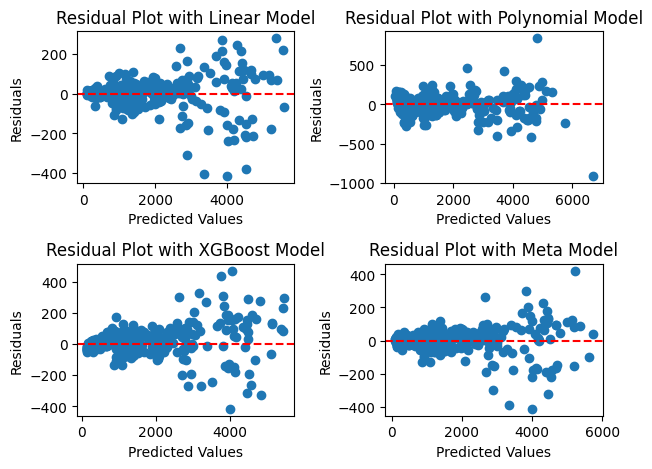

In [ ]:
#Residual Plots
import matplotlib.pyplot as plt
pred_list = [lin_pred, poly_pred, xgb_pred, meta_pred]
model_list = ['Linear', 'Polynomial', 'XGBoost', 'Meta']
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flat):
    if i < len(pred_list):
        residuals = y - pred_list[i]
        ax.scatter(pred_list[i], residuals)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Residuals')
        ax.set_title('Residual Plot with '+model_list[i]+' Model')
plt.tight_layout()
plt.show()

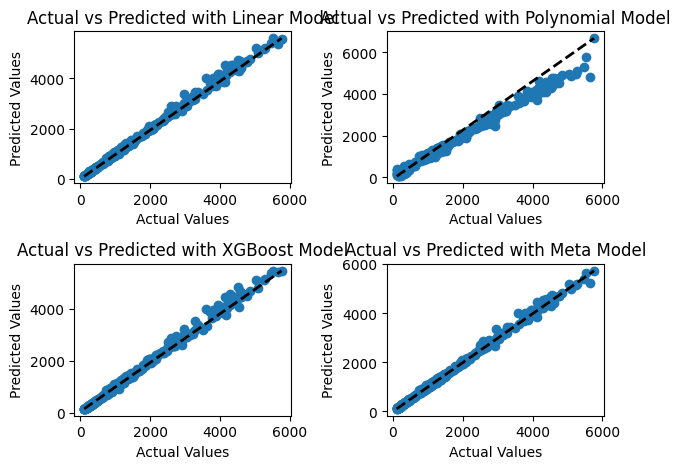

In [ ]:
#Actual vs Predicted Plots
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flat):
    if i < len(pred_list):
        ax.scatter(y, pred_list[i])
        ax.plot([y.min(),y.max()],[pred_list[i].min(),pred_list[i].max()],'k--', lw=2)
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title('Actual vs Predicted with '+model_list[i]+' Model')
plt.tight_layout()
plt.show()

**Conclusion**

1. Meta model has the least MSE score
2. Despite that, it does not vary much from the simple linear regression model
3. Instead, the improvement can mainly be seen on the earlier end of both the residual and actual vs predicted plots, where the scattering points for the meta model is slightly more concentrated. However, when the target values are over around 2500 (i.e. more recent data), we are not quite sure whether an improvement has been made.
4. Anyway, we are using the meta model for deployment because computation complexity is not too much of a concern in this project, while the seemingly slightest improvement in accuracy is favoured

In [ ]:
#exporting models for deployment
import joblib
joblib.dump(meta_model,'/content/drive/My Drive/Colab Notebooks/meta_model.pkl')
joblib.dump(lin_reg,'/content/drive/My Drive/Colab Notebooks/lin_reg.pkl')
joblib.dump(poly_reg,'/content/drive/My Drive/Colab Notebooks/poly_reg.pkl')
joblib.dump(xgb_reg, '/content/drive/My Drive/Colab Notebooks/xgb_reg.pkl')

['/content/drive/My Drive/Colab Notebooks/xgb_reg.pkl']